In [10]:

import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import os
import pandas as pd
from glob import glob
import rioxarray

# Land Cover Dataset

In [11]:
#  Charger les shapefiles Land Cover 
landcover_alg = gpd.read_file("../data/geonetwork_landcover_DZA_gc_adg/dza_gc_adg.shp")
landcover_tun = gpd.read_file("../data/geonetwork_landcover_tun_gc_adg/tun_gc_adg.shp")

print("Land Cover Algeria CRS:", landcover_alg.crs)
print("Land Cover Tunisia CRS:", landcover_tun.crs)

Land Cover Algeria CRS: EPSG:4326
Land Cover Tunisia CRS: EPSG:4326


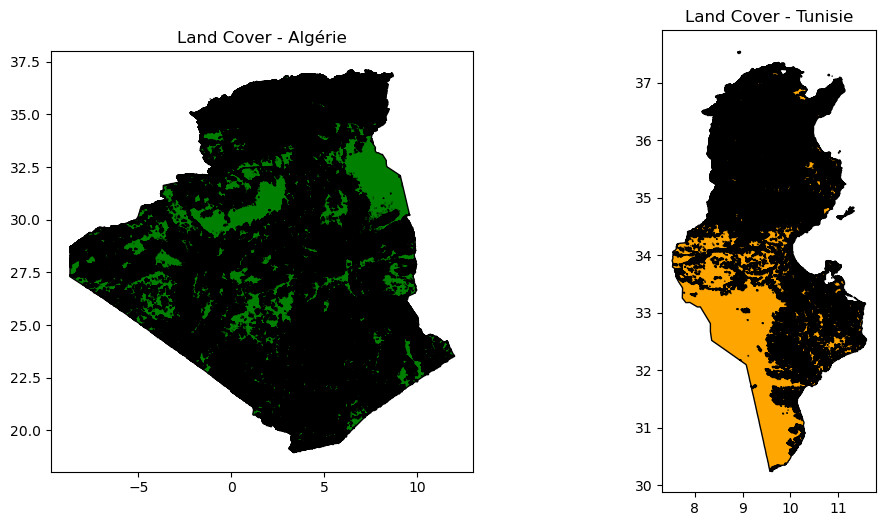

In [12]:
#  Visualiser les Land Cover 
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
landcover_alg.plot(ax=ax[0], color='green', edgecolor='black')
ax[0].set_title("Land Cover - Algérie")
landcover_tun.plot(ax=ax[1], color='orange', edgecolor='black')
ax[1].set_title("Land Cover - Tunisie")
plt.show()

# Climat Dataset

In [13]:

#  Fusionner les deux shapefiles 
landcover = gpd.GeoDataFrame(pd.concat([landcover_alg, landcover_tun], ignore_index=True))
landcover = landcover.dissolve()  # fusion géométrique
landcover = landcover.to_crs("EPSG:4326")  # on force la projection en WGS84 (comme WorldClim)



In [14]:

base_dir = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\Climat"
variables = ["precip", "tmin", "tmax"]


#  Boucle sur chaque variable 
for var in variables:
    
    input_dir = os.path.join(base_dir, var)
    output_dir = os.path.join(base_dir, f"{var}_alg_tun")
    os.makedirs(output_dir, exist_ok=True)
    
    # Lister les fichiers .tif (12 mois * 5 années = 60 fichiers)
    tif_files = sorted(glob(os.path.join(input_dir, "*.tif")))
    
    for tif_file in tif_files:
        try:
            # Charger le raster climatique
            ds = rioxarray.open_rasterio(tif_file)
            
            # Reprojeter le shapefile si besoin
            if landcover.crs != ds.rio.crs:
                landcover = landcover.to_crs(ds.rio.crs)
            
            # Découper avec le shapefile fusionné
            ds_crop = ds.rio.clip(landcover.geometry, landcover.crs)
            
            # Sauvegarder le résultat
            output_path = os.path.join(output_dir, os.path.basename(tif_file))
            ds_crop.rio.to_raster(output_path)
            
        except Exception as e:
            print(f" Erreur sur {os.path.basename(tif_file)} : {e}")
